In [5]:
import re
import numpy as np

def parse_msp_file(msp_file_path, polarity):
    """
    Parses the .msp file to extract all spectrum information.
    
    Args:
        msp_file_path (str): Path to the .msp file.

    Returns:
        dict: A dictionary where keys are InChIKey or SMILES and values are lists of spectra data.
    """
    spectra = {}
    if polarity == "positive":
        p_type = "[M+H]+"
    elif polarity == "posative":
        p_type = "[M-H]-"
    else:
        raise ValueError("Invalid polarity. Please specify 'positive' or 'posative'.")
    
    with open(msp_file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        entries = content.split('Name: ')
        for entry in entries[1:]:
            lines = entry.strip().split('\n')
            metadata = {}
            spectrum_data = []
            key = None

            for line in lines:
                if line.startswith("InChIKey:"):
                    key = line.split(": ")[1].strip()
                elif line.startswith("SMILES:") and key is None:
                    key = line.split(": ")[1].strip()
                elif line.startswith("Spectrum_type:"):
                    spectrum_type = line.split(": ")[1].strip()
                elif line.startswith("Precursor_type:"):
                    precursor_type = line.split(": ")[1].strip()
                elif line.startswith("Num Peaks:"):
                    num_peaks = int(line.split(": ")[1].strip())
                    spectrum_data = lines[lines.index(line)+1:lines.index(line)+1+num_peaks]
                elif ": " in line:
                    k, v = line.split(": ", 1)
                    metadata[k.strip()] = v.strip()

            # Retain only spectra with "Spectrum_type: MS2"
            if spectrum_type == "MS2" and precursor_type == p_type  and key and spectrum_data:
                if key not in spectra:
                    spectra[key] = []
                spectra[key].append({
                    "metadata": metadata,
                    "spectrum": [(float(mz), float(intensity)) for mz, intensity in (line.split() for line in spectrum_data)]
                })

    return spectra


def parse_mona_database(db_file_path, polarity):
    """
    Parses an alternate database format to extract all spectrum information based on polarity.

    Args:
        db_file_path (str): Path to the database file.
        polarity (str): The ion polarity to filter ("positive" or "posative").

    Returns:
        dict: A dictionary where keys are InChIKey or SMILES and values are lists of spectra data.
    """
    spectra = {}

    if polarity == "positive":
        p_type = "[M+H]+"
    elif polarity == "posative":
        p_type = "[M-H]-"
    else:
        raise ValueError("Invalid polarity. Please specify 'positive' or 'posative'.")

    with open(db_file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        entries = content.split('NAME: ')  # "NAME:" marks the beginning of each spectrum.
        for entry in entries[1:]:
            lines = entry.strip().split('\n')
            metadata = {}
            spectrum_data = []
            key = None

            for line in lines:
                if line.startswith("INCHIKEY:"):
                    key = line.split(": ")[1].strip()
                elif line.startswith("SMILES:") and key is None:
                    key = line.split(": ")[1].strip()
                elif line.startswith("PRECURSORTYPE:"):
                    ionization = line.split(": ")[1].strip()
                elif line.startswith("Num Peaks:"):
                    num_peaks = int(line.split(": ")[1].strip())
                    spectrum_data = [tuple(map(float, peak.split())) for peak in lines[lines.index(line)+1:] if peak.strip()]
                elif ": " in line:
                    k, v = line.split(": ", 1)
                    metadata[k.strip()] = v.strip()

            # Retain only spectra matching the desired polarity
            if ionization == p_type and key and spectrum_data:
                if key not in spectra:
                    spectra[key] = []
                spectra[key].append({
                    "metadata": metadata,
                    "spectrum": spectrum_data
                })

    return spectra

import os
from matchms import calculate_scores
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message=".*")

def get_spectrum_by_key(spectra, key):
    """
    Retrieves all spectrum information by InChIKey or SMILES.

    Args:
        spectra (dict): Parsed spectra data.
        key (str): The InChIKey or SMILES to search for.

    Returns:
        dict: A dictionary where keys are collision energies and values are spectra.
    """
    if key not in spectra:
        return {}

    grouped_spectra = {}
    for spec in spectra[key]:
        collision_energy = spec["metadata"].get("Collision_energy", spec["metadata"].get("COLLISIONENERGY", "Unknown"))
        if collision_energy not in grouped_spectra:
            grouped_spectra[collision_energy] = []
        grouped_spectra[collision_energy].append(spec["spectrum"])

    return grouped_spectra

In [2]:
# Example Usage:
database1 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MassBank_NIST.msp"
database2 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MSMS_Public_EXP_NEG_VS17.msp"
database10 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MSMS_Public_EXP_POS_VS17.msp"
database3 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MoNA-export-All_LC-MS-MS_Orbitrap.msp"

#CFMID database
database4 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy0.msp"
database5 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy1.msp"
database6 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy2.msp"

database7 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_pos_energy0.msp"
database8 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_pos_energy1.msp"
database9 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_pos_energy2.msp"

mbank_data_neg = parse_msp_file(database1, polarity="negative")
mona_data_neg = parse_mona_database(database2, polarity="negative")
mona_obtrap_data_neg = parse_msp_file(database3, polarity="negative")
cfmid_e0_data_neg = parse_mona_database(database4, polarity="negative")
cfmid_e1_data_neg = parse_mona_database(database5, polarity="negative")
cfmid_e2_data_neg = parse_mona_database(database6, polarity="negative")

mbank_data_pos = parse_msp_file(database1, polarity="positive")
mona_data_pos = parse_mona_database(database10, polarity="positive")
mona_obtrap_data_pos = parse_msp_file(database3, polarity="positive")
cfmid_e0_data_pos = parse_mona_database(database7, polarity="positive")
cfmid_e1_data_pos = parse_mona_database(database8, polarity="positive")
cfmid_e2_data_pos = parse_mona_database(database9, polarity="positive")

In [43]:
RTlibrary = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/RT_prediction/RT_library_DTSC_lab_166.csv"
plastic_with_predRT = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Manuscript/PlasticChem_predRT.csv"

import pandas as pd
plastic_list = pd.read_csv(plastic_with_predRT)
RT_lib = pd.read_csv(RTlibrary)

In [44]:
#find RT for each row in plastic_list from RT_lib based on INCHIKEY match and add to plastic_list as a new column name RT_lib
for iter, row in plastic_list.iterrows():
    # key = row['INCHIKEY']
    # key = row['PREFERRED_NAME']
    key = row['CASRN']
    RT = RT_lib[RT_lib['CAS'] == key]['RT'].values
    if len(RT) == 0:
        RT = 'NA'
    else:
        RT = RT[0]
    plastic_list.at[iter, 'RT_lib'] = RT

In [45]:
plastic_list[plastic_list['RT_lib'] != 'NA']

,Unnamed: 0,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,DTXCID,INCHIKEY,CASRN,SMILES,MS_READY_SMILES,...,ECHAPLASTICS,CPPDBLISTA,CPPDBLISTB,SMILES_ready,Monoisotopic_Mass_ready,Name,PredRT_rtip,predRT_higher,predRT_lower,RT_lib
88,89,DTXSID0020446,DSSTox_Substance_Id,DTXSID0020446,Diuron,DTXCID00446,XMTQQYYKAHVGBJ-UHFFFAOYSA-N,330-54-1,CN(C)C(=O)NC1=CC(Cl)=C(Cl)C=C1,CN(C)C(=O)NC1=CC(Cl)=C(Cl)C=C1,...,-,-,Y,CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1,232.017018,DTXSID0020446,8.35,12.21,4.49,7.92
126,127,DTXSID0021969,DSSTox_Substance_Id,DTXSID0021969,4-Hydroxy-3-methoxybenzaldehyde,DTXCID301969,MWOOGOJBHIARFG-UHFFFAOYSA-N,121-33-5,COC1=C(O)C=CC(C=O)=C1,COC1=C(O)C=CC(C=O)=C1,...,-,-,Y,COc1cc(C=O)ccc1O,152.047344,DTXSID0021969,4.38,8.24,0.52,4.305
137,138,DTXSID0022480,DSSTox_Substance_Id,DTXSID0022480,3-Ethylphenol,DTXCID402480,HMNKTRSOROOSPP-UHFFFAOYSA-N,620-17-7,CCC1=CC=CC(O)=C1,CCC1=CC=CC(O)=C1,...,-,-,Y,CCc1cccc(O)c1,122.073165,DTXSID0022480,7.32,11.18,3.46,11.228
211,212,DTXSID0029133,DSSTox_Substance_Id,DTXSID0029133,4-Hydroxyacetophenone,DTXCID209133,TXFPEBPIARQUIG-UHFFFAOYSA-N,99-93-4,CC(=O)C1=CC=C(O)C=C1,CC(=O)C1=CC=C(O)C=C1,...,-,-,-,CC(=O)c1ccc(O)cc1,136.052429,DTXSID0029133,4.25,8.11,0.39,4.471
223,224,DTXSID0032316,DSSTox_Substance_Id,DTXSID0032316,"4-Chloro-3,5-dimethylphenol",DTXCID8012316,OSDLLIBGSJNGJE-UHFFFAOYSA-N,88-04-0,CC1=CC(O)=CC(C)=C1Cl,CC1=CC(O)=CC(C)=C1Cl,...,-,-,-,Cc1cc(O)cc(C)c1Cl,156.034193,DTXSID0032316,9.30,13.16,5.44,9.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4786,4787,DTXSID9026261,DSSTox_Substance_Id,DTXSID9026261,"Tris(1,3-dichloro-2-propyl) phosphate",DTXCID206261,ASLWPAWFJZFCKF-UHFFFAOYSA-N,13674-87-8,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,...,Y,-,Y,O=P(OC(CCl)CCl)(OC(CCl)CCl)OC(CCl)CCl,427.883912,DTXSID9026261,11.68,15.54,7.82,11.581
4843,4844,DTXSID9027441,DSSTox_Substance_Id,DTXSID9027441,Octabenzone,DTXCID107441,QUAMTGJKVDWJEQ-UHFFFAOYSA-N,1843-05-6,CCCCCCCCOC1=CC(O)=C(C=C1)C(=O)C1=CC=CC=C1,CCCCCCCCOC1=CC(O)=C(C=C1)C(=O)C1=CC=CC=C1,...,Y,Y,-,CCCCCCCCOc1ccc(C(=O)c2ccccc2)c(O)c1,326.188195,DTXSID9027441,15.95,19.81,12.09,16.016
4869,4870,DTXSID9041653,DSSTox_Substance_Id,DTXSID9041653,Methyl 3-methylorsellinate,DTXCID7021653,UUQHKWMIDYRWHH-UHFFFAOYSA-N,4707-47-5,COC(=O)C1=C(O)C(C)=C(O)C=C1C,COC(=O)C1=C(O)C(C)=C(O)C=C1C,...,-,-,-,COC(=O)c1c(C)cc(O)c(C)c1O,196.073559,DTXSID9041653,7.63,11.49,3.77,8.267
4885,4886,DTXSID9044534,DSSTox_Substance_Id,DTXSID9044534,4-Acetylphenyl acetate,DTXCID7024534,SMIOEQSLJNNKQF-UHFFFAOYSA-N,13031-43-1,CC(=O)OC1=CC=C(C=C1)C(C)=O,CC(=O)OC1=CC=C(C=C1)C(C)=O,...,-,-,Y,CC(=O)Oc1ccc(C(C)=O)cc1,178.062994,DTXSID9044534,3.71,7.57,-0.15,2.903


You should consider upgrading via the 'd:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\Scripts\python.exe -m pip install --upgrade pip' command.


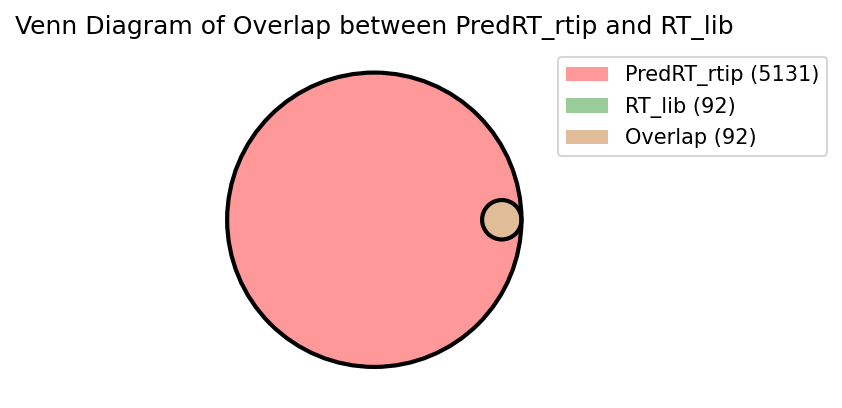

In [46]:
#make a venn diagram of the overlap between the PredRT_rtip and RT_lib
%pip install matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles
# Extract sets of InChIKeys for PredRT_rtip and RT_lib
predRT_rtip_set = set(plastic_list[plastic_list['PredRT_rtip'].notna()]['INCHIKEY'])
RT_lib_set = set(plastic_list[plastic_list['RT_lib'] != 'NA']['INCHIKEY'])

# Create the Venn diagram
plt.figure(figsize=(4, 3), dpi=150)
venn = venn2([predRT_rtip_set, RT_lib_set], ('PredRT_rtip', 'RT_lib'))
venn2_circles([predRT_rtip_set, RT_lib_set])

plt.title("Venn Diagram of Overlap between PredRT_rtip and RT_lib")

# Remove labels inside the Venn diagram circles
for text in venn.subset_labels:
    text.set_text('')

# Remove labels for the groups
for text in venn.set_labels:
    text.set_text('')

# Add legend to the plot with the counts
plt.legend([f'PredRT_rtip ({len(predRT_rtip_set)})', f'RT_lib ({len(RT_lib_set)})', 
            f'Overlap ({len(predRT_rtip_set & RT_lib_set)})'], loc='upper left', bbox_to_anchor=(1, 1))

# Save the figure
plt.savefig("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Manuscript/venn_diagram_RT.png", format='png', dpi=300)

plt.show()


In [47]:
#perform spectrum search for each row by InChiKey_origin column, and add number of found spectra to the dataframe from each database.

for iter, row in plastic_list.iterrows():
    key = row['INCHIKEY']
    mbank_spectra = get_spectrum_by_key(mbank_data_neg, key)
    mona_spectra = get_spectrum_by_key(mona_data_neg, key)
    mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data_neg, key)
    cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data_neg, key)
    cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data_neg, key)   
    cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data_neg, key)
    plastic_list.loc[iter, 'mbank_data_neg'] = len(mbank_spectra.keys())
    plastic_list.loc[iter, 'mona_spectra_neg'] = len(mona_spectra.keys())
    plastic_list.loc[iter, 'mona_obtrap_spectra_neg'] = len(mona_obtrap_spectra.keys())
    plastic_list.loc[iter, 'total_lib_spectra_neg'] = len(mbank_spectra.keys()) + len(mona_spectra.keys()) + len(mona_obtrap_spectra.keys())
    plastic_list.loc[iter, 'cfmid_e0_spectra_neg'] = len(cfmid_e0_spectra.keys())
    plastic_list.loc[iter, 'cfmid_e1_spectra_neg'] = len(cfmid_e1_spectra.keys())
    plastic_list.loc[iter, 'cfmid_e2_spectra_neg'] = len(cfmid_e2_spectra.keys())
    plastic_list.loc[iter, 'total_pred_spectra_neg'] = len(cfmid_e2_spectra.keys()) + len(cfmid_e1_spectra.keys()) + len(cfmid_e0_spectra.keys())
    plastic_list.loc[iter, 'total_spectra_neg'] = len(mbank_spectra.keys()) + len(mona_spectra.keys()) + len(mona_obtrap_spectra.keys()) + len(cfmid_e0_spectra.keys()) + len(cfmid_e1_spectra.keys()) + len(cfmid_e2_spectra.keys())


In [48]:
for iter, row in plastic_list.iterrows():
    key = row['INCHIKEY']
    mbank_spectra = get_spectrum_by_key(mbank_data_pos, key)
    mona_spectra = get_spectrum_by_key(mona_data_pos, key)
    mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data_pos, key)
    cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data_pos, key)
    cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data_pos, key)   
    cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data_pos, key)
    plastic_list.loc[iter, 'mbank_data_pos'] = len(mbank_spectra.keys())
    plastic_list.loc[iter, 'mona_spectra_pos'] = len(mona_spectra.keys())
    plastic_list.loc[iter, 'mona_obtrap_spectra_pos'] = len(mona_obtrap_spectra.keys())
    plastic_list.loc[iter, 'total_lib_spectra_pos'] = len(mbank_spectra.keys()) + len(mona_spectra.keys()) + len(mona_obtrap_spectra.keys())
    plastic_list.loc[iter, 'cfmid_e0_spectra_pos'] = len(cfmid_e0_spectra.keys())
    plastic_list.loc[iter, 'cfmid_e1_spectra_pos'] = len(cfmid_e1_spectra.keys())
    plastic_list.loc[iter, 'cfmid_e2_spectra_pos'] = len(cfmid_e2_spectra.keys())
    plastic_list.loc[iter, 'total_pred_spectra_pos'] = len(cfmid_e2_spectra.keys()) + len(cfmid_e1_spectra.keys()) + len(cfmid_e0_spectra.keys())
    plastic_list.loc[iter, 'total_spectra_pos'] = len(mbank_spectra.keys()) + len(mona_spectra.keys()) + len(mona_obtrap_spectra.keys()) + len(cfmid_e0_spectra.keys()) + len(cfmid_e1_spectra.keys()) + len(cfmid_e2_spectra.keys())


In [59]:
#add the nuber of spectra from total_lib_spectra_neg and total_lib_spectra_pos to the dataframe as the new column name total_lib_spectra
plastic_list['total_lib_spectra'] = plastic_list['total_lib_spectra_neg'] + plastic_list['total_lib_spectra_pos']
plastic_list['total_pred_spectra'] = plastic_list['total_pred_spectra_neg'] + plastic_list['total_pred_spectra_pos']
plastic_list['total_spectra'] = plastic_list['total_lib_spectra'] + plastic_list['total_pred_spectra']   

In [49]:
#use tabulate to print the table of the above rows
from tabulate import tabulate
print(tabulate(plastic_list[(plastic_list['total_spectra_neg'] == 0) & (plastic_list['total_spectra_pos'] == 0) & (plastic_list['RT_lib'] == 'NA') & (plastic_list['PredRT_rtip'].isna())], headers='keys', tablefmt='psql'))

+------+--------------+-----------------+---------------------+-----------------+-------------------------------------------------------------------------------------------------------------------------------------+-----------------+-----------------------------+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+---------------------+---------------------+-------------------------+------------+------------+--------------------------------------------------------------------------------------------------------------------------------------------------

In [51]:
#summary of the number of compounds with no spectra in any database
print(len(plastic_list[(plastic_list['total_spectra_neg'] == 0) & (plastic_list['total_spectra_pos'] == 0) & (plastic_list['RT_lib'] == 'NA') & (plastic_list['PredRT_rtip'].isna())]))


2


In [60]:
#summary of the number of compounds with total_lib_spectra_neg > 0
print(len(plastic_list[plastic_list['total_lib_spectra_neg'] > 0]))
#summary of the number of compounds with total_pred_spectra_neg > 0
print(len(plastic_list[plastic_list['total_pred_spectra_neg'] > 0]))
#summary of the number of compounds with total_lib_spectra_pos > 0
print(len(plastic_list[plastic_list['total_lib_spectra_pos'] > 0]))
#summary of the number of compounds with total_pred_spectra_pos > 0
print(len(plastic_list[plastic_list['total_pred_spectra_pos'] > 0]))
#summary of the number of compounds with total_lib_spectra > 0
print(len(plastic_list[plastic_list['total_lib_spectra'] > 0]))
#summary of the number of compounds with total_pred_spectra > 0
print(len(plastic_list[plastic_list['total_pred_spectra'] > 0]))
#summary of the number of compounds with total_spectra > 0
print(len(plastic_list[plastic_list['total_spectra'] > 0]))

328
4052
614
4249
725
4252
4254


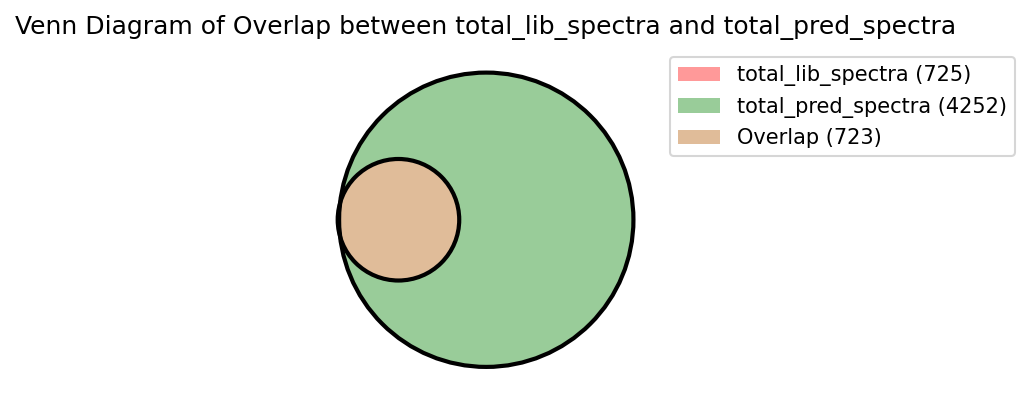

In [61]:
#make a venn diagram of the overlap between the total_lib_spectra and total_pred_spectra
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles
# Extract sets of InChIKeys for total_lib_spectra and total_pred_spectra
total_lib_spectra_set = set(plastic_list[plastic_list['total_lib_spectra'] > 0]['INCHIKEY'])
total_pred_spectra_set = set(plastic_list[plastic_list['total_pred_spectra'] > 0]['INCHIKEY'])

# Create the Venn diagram
plt.figure(figsize=(4, 3), dpi=150)
venn = venn2([total_lib_spectra_set, total_pred_spectra_set], ('total_lib_spectra', 'total_pred_spectra'))
venn2_circles([total_lib_spectra_set, total_pred_spectra_set])

plt.title("Venn Diagram of Overlap between total_lib_spectra and total_pred_spectra")

# Remove labels inside the Venn diagram circles
for text in venn.subset_labels:
    text.set_text('')
# Remove labels for the groups

for text in venn.set_labels:
    text.set_text('')
# Add legend to the plot with the counts
plt.legend([f'total_lib_spectra ({len(total_lib_spectra_set)})', f'total_pred_spectra ({len(total_pred_spectra_set)})', 
            f'Overlap ({len(total_lib_spectra_set & total_pred_spectra_set)})'], loc='upper left', bbox_to_anchor=(1, 1))

# Save the figure
# plt.savefig("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Manuscript/venn_diagram_total_lib_pred.png", format='png', dpi=300)
plt.show()
